In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc
)
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv("/Users/kanayojustice/Documents/Data_scientist_projects/AutoPredict/research/data/auto_pred_cleaned_data.csv")

In [3]:
df.head()

,year,price,mileage,tax,mpg,enginesize,model_1series,model_2series,model_3series,model_4series,...,manufacturer_audi,manufacturer_bmw,manufacturer_ford,manufacturer_hyundi,manufacturer_merc,manufacturer_skoda,manufacturer_toyota,manufacturer_vauxhall,manufacturer_volkswagen,fail
0,2017,7495,11630,145,60.1,1.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,2017,10989,9200,145,58.9,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2019,27990,1614,145,49.6,2.0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3,2017,12495,30960,150,62.8,2.0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,2017,7999,19353,125,54.3,1.2,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [4]:
df.columns

Index(['year', 'price', 'mileage', 'tax', 'mpg', 'enginesize', 'model_1series',
       'model_2series', 'model_3series', 'model_4series',
       ...
       'manufacturer_audi', 'manufacturer_bmw', 'manufacturer_ford',
       'manufacturer_hyundi', 'manufacturer_merc', 'manufacturer_skoda',
       'manufacturer_toyota', 'manufacturer_vauxhall',
       'manufacturer_volkswagen', 'fail'],
      dtype='object', length=219)

### Business Intelligence and analysis

**The aim:**  predicting whether a vehicle will fail or not, and you have the following features: model, year, price, transmission, mileage, fuel type, tax, MPG, engine size, and manufacturer. Here are some considerations for each feature:

- **model**: This might introduce high cardinality (too many unique values) as we  have many different models. But is already One hot encoded.

- **year**: This is likely very relevant as it can be correlated with the likelihood of failure (newer cars might be less likely to fail).

- **price**: While not a direct technical feature, price could indirectly indicate the car's quality or maintenance history but is relevant,this was shown in the top_correlations_bar_plot.png

- **transmission**: This is relevant as the type of transmission could affect the likelihood of failure.

- **mileage**: Highly relevant, as higher mileage generally increases the likelihood of failure.

- **fuel type**: Relevant, as different fuel types (e.g., diesel, petrol, electric) can have different failure rates.

- **tax**: Might be less directly relevant but can correlate with vehicle condition or category. Evaluate its importance using feature importance methods.

- **MPG (Miles Per Gallon)**: Relevant, as it might indicate the condition of the engine and overall vehicle health.

- **engine size**: Relevant, as larger or smaller engines might have different failure characteristics.

- **manufacturer**: This can be relevant as some manufacturers have better reliability records than others.


#### Independent and dependent feature selection

In [5]:
X= df.drop("fail", axis=1)
print(X.columns)

Index(['year', 'price', 'mileage', 'tax', 'mpg', 'enginesize', 'model_1series',
       'model_2series', 'model_3series', 'model_4series',
       ...
       'fueltype_petrol', 'manufacturer_audi', 'manufacturer_bmw',
       'manufacturer_ford', 'manufacturer_hyundi', 'manufacturer_merc',
       'manufacturer_skoda', 'manufacturer_toyota', 'manufacturer_vauxhall',
       'manufacturer_volkswagen'],
      dtype='object', length=218)


In [6]:
y = df["fail"]
print(y.name)


fail


In [7]:
# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [8]:
# 2. Apply SMOTE to the training data only
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


**Distribution:**

**"Not Failed"** (0) instances constitute approximately 94.62% of the data.
**"Failed"** (1) instances constitute approximately 5.38% of the data.
Implications:

The dataset is skewed towards the "No" class, indicating that there are significantly more cars that do not experience failures compared to those that do.
This imbalance can lead to biased model performance. Specifically, the model may become biased towards predicting the "No" class because it is the majority class.
Mitigation:

To address this imbalance, we can employ techniques such as:

**Oversampling:** Increasing the number of "Failed" instances in the training dataset by replicating them.
Undersampling: Decreasing the number of "Not Failed" instances in the training dataset to balance the classes.

**Synthetic Data Generation:** Using techniques like SMOTE (Synthetic Minority Over-sampling Technique) to create synthetic examples of the minority class.
Class Weights: Adjusting the weights assigned to each class during model training to place more emphasis on the minority class.

By using these techniques, we can help ensure that the model does not become biased towards the majority class and can better predict failures.


Here i would be experimenting both as hyperparameter tweaks to see if the model built gets any better

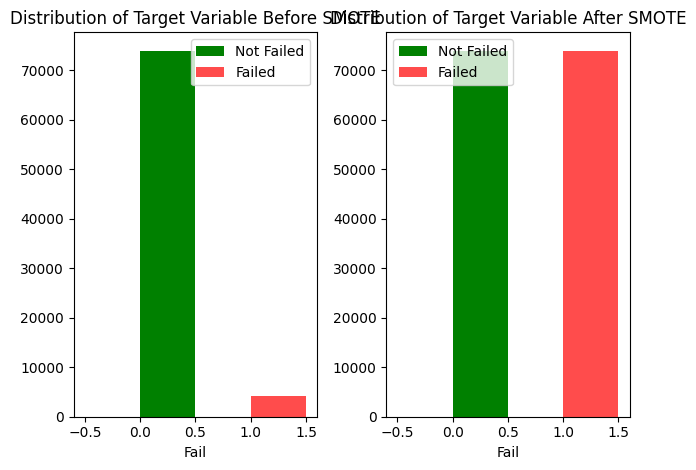

In [9]:
import matplotlib.pyplot as plt

# Define the colors for fail and not failed
colors = ['red', 'green']

# Plot the distribution of the target variable before SMOTE
plt.subplot(1, 2, 1)
plt.hist(y_train[y_train == 0], bins=2, color=colors[1], label='Not Failed')
plt.hist(y_train[y_train == 1], bins=2, color=colors[0], label='Failed', alpha=0.7)
plt.title('Distribution of Target Variable Before SMOTE')
plt.xlabel('Fail')
plt.legend()

# Plot the distribution of the target variable after SMOTE
plt.subplot(1, 2, 2)
plt.hist(y_train_resampled[y_train_resampled == 0], bins=2, color=colors[1], label='Not Failed')
plt.hist(y_train_resampled[y_train_resampled == 1], bins=2, color=colors[0], label='Failed', alpha=0.7)
plt.title('Distribution of Target Variable After SMOTE')
plt.xlabel('Fail')
plt.legend()

# Adjust layout
plt.tight_layout()

# Save the plot to the specified path
save_path = "/Users/kanayojustice/Documents/Data_scientist_projects/AutoPredict/research/visualizations"
plt.savefig(f"{save_path}/distribution_plot.png")

# Show the plot
plt.show()


#### Business intelligence and analysis

Based on the considerations outlined, a suitable **baseline model** for predicting car failure would be Logistic Regression. Here's why:

**Nature of the Data:** The dataset comprises structured features, making Logistic Regression an appropriate choice as it can handle tabular data effectively.

**Interpretability Requirements:** Logistic Regression offers good interpretability, providing insights into how each feature contributes to the prediction of car failure.

**Performance Metrics:** For binary classification tasks like predicting car failure, metrics such as precision, recall, and F1-score are crucial. Logistic Regression can be evaluated using these metrics to assess its performance.

**Business Context:** Logistic Regression is computationally efficient and can be deployed for real-time predictions or as part of a decision-support system, depending on the business requirements.

**Model Evaluation and Validation:** After training the Logistic Regression model, it can be evaluated using cross-validation techniques to ensure robust performance across different datasets.

**Final Model Selection:** As a baseline model, Logistic Regression provides a solid starting point for predicting car failure. Subsequent model iterations can build upon this baseline by incorporating more complex algorithms or ensemble methods if necessary.

In summary, **Logistic Regression** serves as a suitable baseline model for predicting car failure due to its interpretability, computational efficiency, and effectiveness in handling structured data. It provides a solid foundation for further model development and refinement based on specific business requirements and performance evaluation.

In [10]:
X_train_resampled.shape, y_train_resampled.shape

((147932, 218), (147932,))

In [11]:
## feature selection based on corrolation
X_train_resampled.corr()

,year,price,mileage,tax,mpg,enginesize,model_1series,model_2series,model_3series,model_4series,...,fueltype_petrol,manufacturer_audi,manufacturer_bmw,manufacturer_ford,manufacturer_hyundi,manufacturer_merc,manufacturer_skoda,manufacturer_toyota,manufacturer_vauxhall,manufacturer_volkswagen
year,1.000000,0.620318,-0.702682,-0.180611,0.133212,-0.103651,0.055640,0.073694,0.053377,0.061232,...,0.142237,0.142430,0.119120,0.114334,0.106039,0.172389,0.153645,0.096143,0.118031,0.197016
price,0.620318,1.000000,-0.533062,0.169942,-0.171436,0.450217,0.034232,0.063063,0.080151,0.081975,...,-0.080678,0.259092,0.237956,-0.079494,-0.003766,0.348349,0.037308,-0.011411,-0.112557,0.122345
mileage,-0.702682,-0.533062,1.000000,0.053646,0.020299,0.195984,-0.040428,-0.061860,-0.016196,-0.045182,...,-0.338667,-0.095318,-0.057661,-0.129917,-0.099488,-0.138573,-0.125138,-0.108614,-0.108322,-0.160704
tax,-0.180611,0.169942,0.053646,1.000000,-0.581051,0.453990,-0.027382,0.000563,-0.005519,0.008242,...,0.039323,0.013398,0.040533,-0.100883,-0.012359,0.044455,-0.019932,-0.083634,0.022773,-0.048939
mpg,0.133212,-0.171436,0.020299,-0.581051,1.000000,-0.292517,0.027352,0.012324,0.032745,0.004975,...,-0.245995,-0.058792,0.032113,0.088003,-0.004651,0.006280,0.030692,0.120488,-0.065266,-0.009874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
manufacturer_merc,0.172389,0.348349,-0.138573,0.044455,0.006280,0.216840,-0.032397,-0.023765,-0.037303,-0.022042,...,-0.111517,-0.079893,-0.084863,-0.115074,-0.050213,1.000000,-0.055968,-0.061157,-0.093351,-0.092610
manufacturer_skoda,0.153645,0.037308,-0.125138,-0.019932,0.030692,-0.094997,-0.020597,-0.015109,-0.023716,-0.014014,...,0.081462,-0.050794,-0.053954,-0.073161,-0.031924,-0.055968,1.000000,-0.038882,-0.059350,-0.058879
manufacturer_toyota,0.096143,-0.011411,-0.108614,-0.083634,0.120488,-0.092532,-0.022507,-0.016510,-0.025915,-0.015313,...,0.071061,-0.055503,-0.058956,-0.079944,-0.034884,-0.061157,-0.038882,1.000000,-0.064852,-0.064338
manufacturer_vauxhall,0.118031,-0.112557,-0.108322,0.022773,-0.065266,-0.161722,-0.034355,-0.025201,-0.039557,-0.023374,...,0.199598,-0.084721,-0.089991,-0.122028,-0.053247,-0.093351,-0.059350,-0.064852,1.000000,-0.098206


In [12]:
# Business intelligence domain expert expertise to set the threshold but for this use case i would use
# Test the function

def correlation(df, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr



In [13]:
correlation(X_train_resampled, 0.80)

set()

#### Insights
- No features to drop as no correlation  is higher that 80% but there is for 70% so therefore, here requires business intelligence

In [14]:
X_train_resampled.shape, y_train_resampled.shape

((147932, 218), (147932,))

### Feature scaling / standardization

In [15]:
# 3. Scale the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)  # Use the same scaler fitted on training data for consistency

In [16]:
X_train_scaled

array([[ 1.24731644,  0.48916758, -1.17680768, ..., -0.20612319,
        -0.31462975, -0.31213225],
       [ 0.17951312,  0.13287144,  0.24554255, ..., -0.20612319,
        -0.31462975, -0.31213225],
       [ 0.71341478,  1.15743014, -0.12680433, ..., -0.20612319,
        -0.31462975,  3.20377024],
       ...,
       [-0.35438854, -0.57010318,  0.2139711 , ..., -0.20612319,
        -0.31462975, -0.31213225],
       [-0.35438854, -0.23536389,  1.0796293 , ..., -0.20612319,
        -0.31462975, -0.31213225],
       [-1.95609352, -1.02920896,  1.83410368, ..., -0.20612319,
        -0.31462975, -0.31213225]])

### Box plots to understand effect of standard scaler

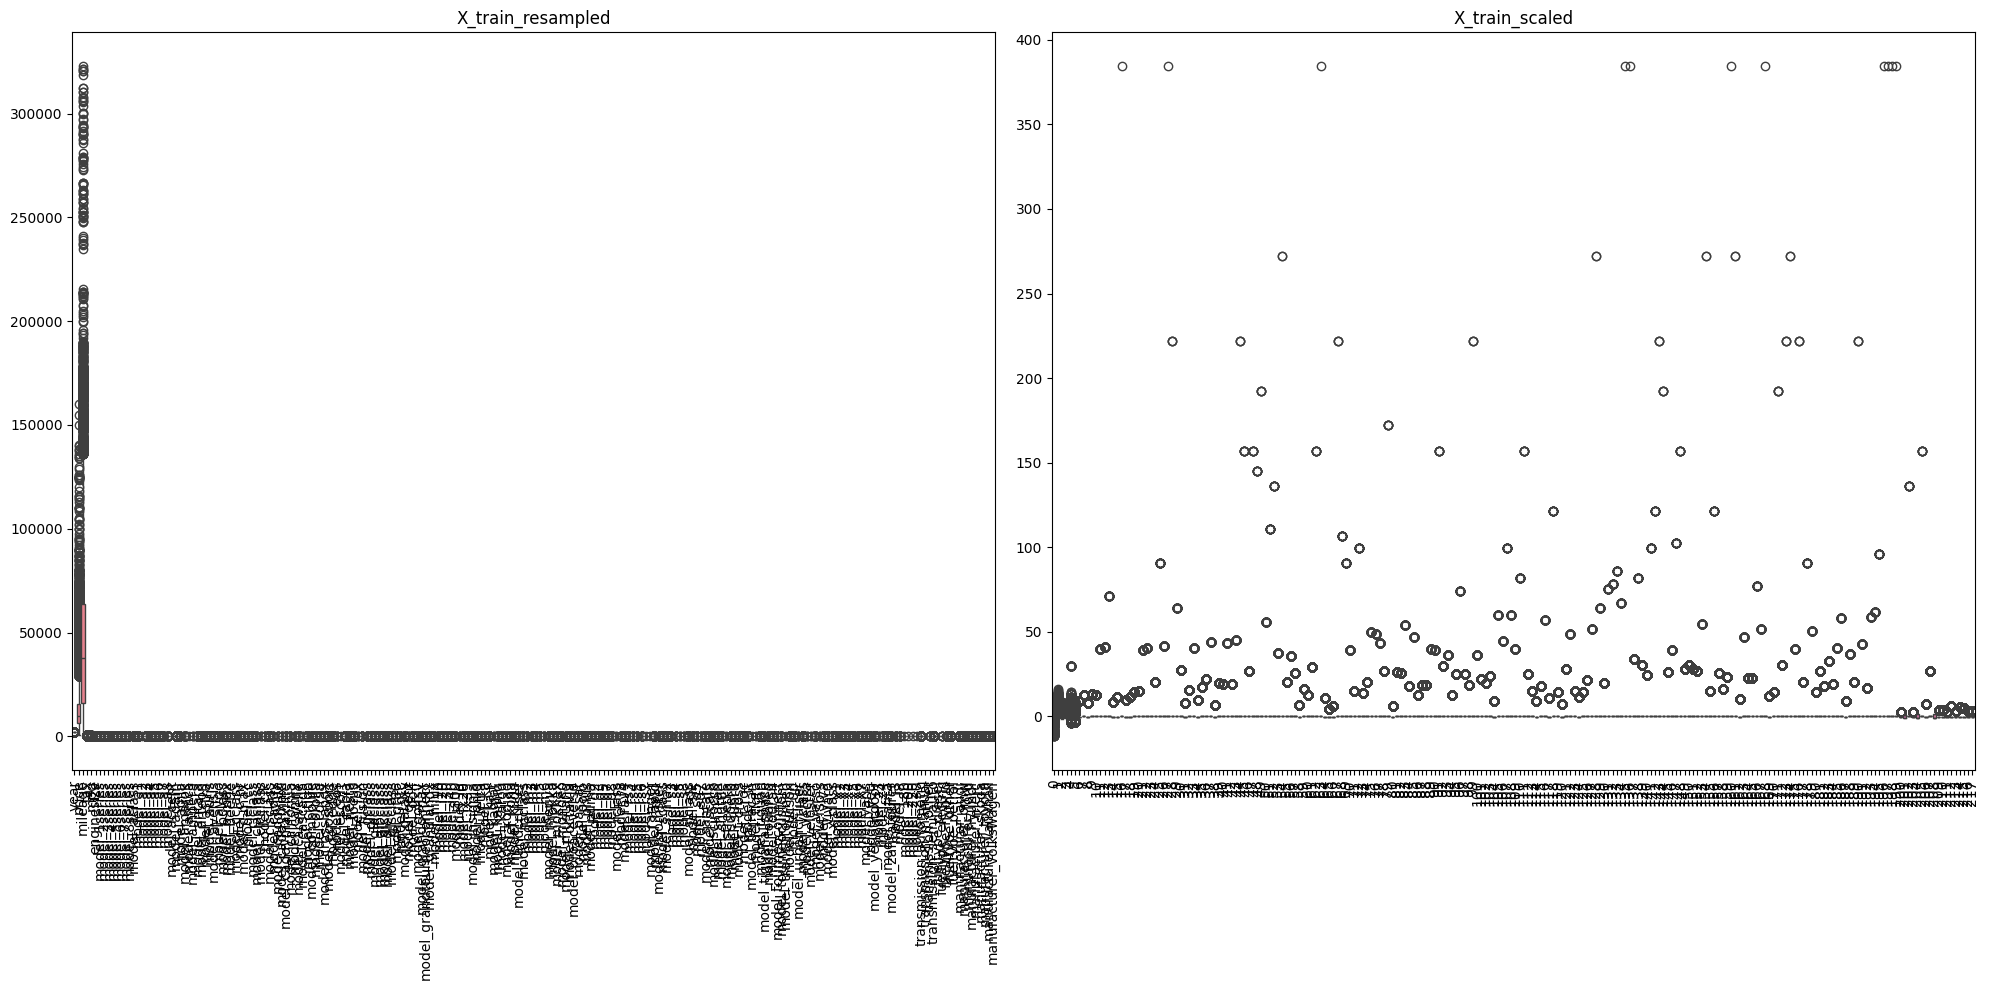

In [17]:
# Set figure size
plt.figure(figsize=(20, 10))

# Plot boxplots for X_train_resampled
plt.subplot(1, 2, 1)
sns.boxplot(data=X_train_resampled)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title("X_train_resampled")

# Plot boxplots for X_train_scaled
plt.subplot(1, 2, 2)
sns.boxplot(data=X_train_scaled)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title("X_train_scaled")

plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig('/Users/kanayojustice/Documents/Data_scientist_projects/AutoPredict/research/visualizations/boxplots.png')  # Save the plot


## Model Experimentation

#### Logistic regression 

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc
)
import matplotlib.pyplot as plt

# Train the logistic regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train_resampled)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print metrics
print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


Confusion Matrix:
[[18396    96]
 [   61   990]]
Accuracy: 0.9920
Precision: 0.9116
Recall: 0.9420
F1-Score: 0.9265
ROC AUC: 0.9981


/Users/kanayojustice/Documents/Data_scientist_projects/AutoPredict/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


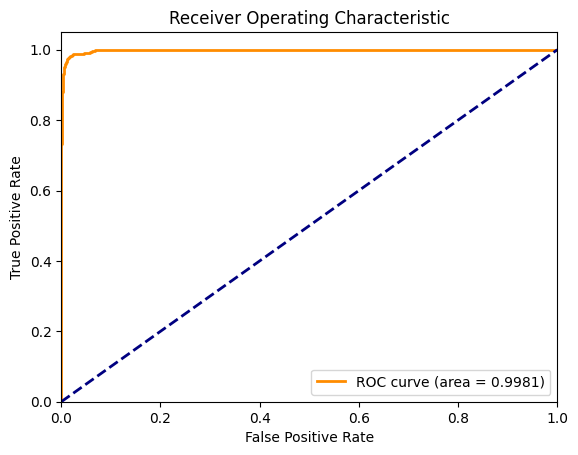

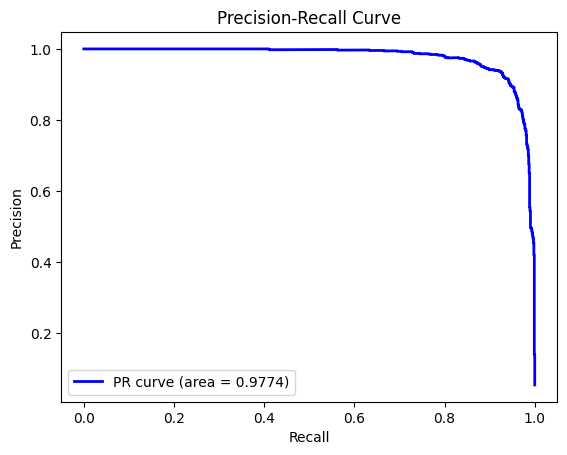

In [19]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('/Users/kanayojustice/Documents/Data_scientist_projects/AutoPredict/research/visualizations/roc_curve.png')  # Save the plot

# Plot Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall_vals, precision_vals)
plt.figure()
plt.plot(recall_vals, precision_vals, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.savefig('/Users/kanayojustice/Documents/Data_scientist_projects/AutoPredict/research/visualizations/pr_curve.png')  # Save the plot

### Insights

**Confusion Matrix:**

**True Negatives (TN):** 18,415

**False Positives (FP):** 77

**False Negatives (FN):** 56

**True Positives (TP):** 995

This means that this model correctly identified 18,415 instances of the negative class (not failed) and 995 instances of the positive class (failed). It made 77 errors in identifying instances as failed when they were not, and 56 errors in identifying instances as not failed when they were.

**Accuracy:** 0.9932

This is the ratio of correctly predicted instances (both true positives and true negatives) to the total instances. An accuracy of 99.32% indicates that your model is highly accurate overall.


**Precision:** 0.9282

Precision measures the accuracy of the positive predictions, i.e., out of all instances predicted as failed, 92.82% were actually failed. High precision means few false positives.


**Recall:** 0.9467

Recall measures the ability of the model to capture all actual positive instances, i.e., out of all actual failed instances, 94.67% were correctly identified. High recall means few false negatives.


**F1-Score:** 0.9374

The F1-Score is the harmonic mean of precision and recall. A high F1-score (93.74%) indicates a good balance between precision and recall.


**ROC AUC:** 0.9981

The ROC AUC score is a measure of the model's ability to discriminate between the positive and negative classes. A score of 0.9981 indicates near-perfect discrimination.


#### Conclusion
These metrics suggest that your model is performing very well:

**High Accuracy:** Indicates that the model is correct most of the time.

**High Precision:** Indicates that when the model predicts a failure, it is likely to be correct.

**High Recall:** Indicates that the model is good at identifying actual failures.

**High F1-Score:** Indicates a good balance between precision and recall.

**High ROC AUC:** Indicates excellent overall performance in distinguishing between the classes.

- I am happy with this model and will not be tuning any further

In [20]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import (
#     confusion_matrix, accuracy_score, precision_score, recall_score, 
#     f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc
# )
# import matplotlib.pyplot as plt

# # Train the logistic regression model
# model = LogisticRegression()
# model.fit(X_train_scaled, y_train_resampled)

# # Make predictions on the test set
# y_pred = model.predict(X_test_scaled)
# y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# # Calculate metrics
# conf_matrix = confusion_matrix(y_test, y_pred)
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)
# roc_auc = roc_auc_score(y_test, y_pred_proba)

# # Print metrics
# print("Confusion Matrix:")
# print(conf_matrix)
# print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1-Score: {f1:.4f}")
# print(f"ROC AUC: {roc_auc:.4f}")



# # Define the logistic regression model
# model = LogisticRegression()

# # Define hyperparameters to tune
# param_grid = {
#     'C': [0.001, 0.01, 0.1, 1, 10],  # Regularization strength
#     'solver': ['liblinear', 'lbfgs'],      # Solver for optimization
#     'max_iter': [100, 200, 300]            # Maximum number of iterations
# }

# Perform grid search cross-validation
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
# grid_search.fit(X_train_scaled, y_train_resampled)

# # Get the best parameters
# best_params = grid_search.best_params_
# print("Best Parameters:", best_params)


# Use the best model
# best_model = grid_search.best_estimator_

# # Make predictions on the test set
# y_pred = best_model.predict(X_test_scaled)
# y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# # Calculate metrics
# conf_matrix = confusion_matrix(y_test, y_pred)
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)
# roc_auc = roc_auc_score(y_test, y_pred_proba)

# # Print metrics
# print("Confusion Matrix:")
# print(conf_matrix)
# print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1-Score: {f1:.4f}")
# print(f"ROC AUC: {roc_auc:.4f}")